In [1]:
import nltk, re, os
import numpy as np
from matplotlib import pyplot as plt
from nltk.tokenize import texttiling, sent_tokenize, word_tokenize
from nltk.corpus import brown

### TextTiling

#### Test123

In [3]:
test_text = brown.raw()[:1000]
tt_en = texttiling.TextTilingTokenizer(demo_mode=False)
# tt_en.tokenize(test_text)

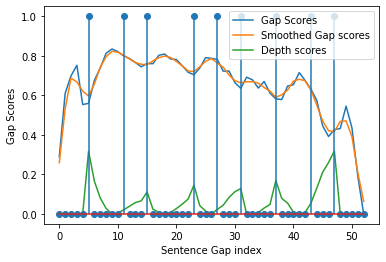

In [2]:
texttiling.demo()

#### Grab text

Gebruik data-analyse om parameters (hoeveelheid woorden in zin voor W; hoeveelheid zinnen in paragraaf voor K; etc.) op te baseren.

In [51]:
class texttilingX(texttiling.TextTilingTokenizer):
    """
    Extension of nltk.texttiling module.
    """
    def __init__(self, text: str, section_mark='===', **kwargs):
        super().__init__(**kwargs)
        t = re.sub(r'^(?:(<doc)|(\n<\/doc)).*\n', '', text, flags=re.MULTILINE) # Clean wiki-markup
        self.text = re.sub(r'\n\n', r'\n', t) # Get rid of double newlines
        self.section_mark = section_mark

    def tokenize(self):
        t = re.sub(fr'^{self.section_mark}.*\n', '', self.text, flags=re.MULTILINE) # Remove headers
        return super().tokenize(text=re.sub('\n', '\n\n', t))

    def word_tokenize(self):
        """
        Returns all the words in the text (in the same fashion as nltk texttiling).
        """
        t = re.sub(fr'^{self.section_mark}.*\n', '', self.text, flags=re.MULTILINE) # Remove headers
        # Don't instantly use re.findall() to find words - nltk package removes just punctuation first as follows:
        nopunct_t = "".join(re.findall(r"[\wÀ-ÖØ-öø-ÿ\-\' \n\t]", t.lower()))
        return re.findall(r"[\wÀ-ÖØ-öø-ÿ\-\']+", nopunct_t)

    def get_truth(self):
        t = re.sub(fr'^{self.section_mark}.*\n', f'{self.section_mark}', self.text, flags=re.MULTILINE) # Remove headers, but add '===' at the start of section
        nopunct_t = "".join(re.findall(fr"(?:[\wÀ-ÖØ-öø-ÿ\-\' \n\t]|{self.section_mark})", t.lower()))
        sep_t = re.findall(fr"(?:[\wÀ-ÖØ-öø-ÿ\-\']|{self.section_mark})+", nopunct_t) # Grab all words (inc. starting with '==='); ignore punctuation etc.
        return [1 if s.startswith(f'{self.section_mark}') else 0 for s in sep_t]

    def plot(self, s, ss, d, b):
        """
        The scores represent the score of token-sequence GAPS.
        So a boundary score of 1 at i=0 means that a boundary occurs between segments 0 and 1.
        To plot this out per words, we translate the token-sequence gaps to the beginning of a new sequence by shifting everything right and adding a 0 at the start.
        Additionally adds a 0 at the end to signify the very last word.
        """
        # Shift to the right + add ending 0
        s_adj = [0] + s + [0]
        ss_adj = [0] + ss + [0]
        d_adj = [0] + d + [0]
        b_adj = [1] + b + [0] # Start of text is always a boundary, kinda
        ground_truth = self.get_truth()

        word_n = len(self.word_tokenize())
        word_indices = np.append(np.arange(len(s_adj[:-1])) * self.w, word_n)

        # Setup the labels for xticks to point towards the start of sentences (for use in ax.set_xticks())
        labels = []
        labels_loc = []
        last_loc = 0
        cur_loc = 0
        max_len = len(str(word_n))
        min_distance = int(np.rint(word_n * 0.02)) # Max distance between labels is ~2% of max words
        t = re.sub(r'^===.*\n', '', self.text, flags=re.MULTILINE)
        for s in sent_tokenize(t):
            nopunct_s = "".join(re.findall(r"[\wÀ-ÖØ-öø-ÿ\-\' ]", s))
            sep_s = re.findall(r"[\wÀ-ÖØ-öø-ÿ\-\']+", nopunct_s)
            if cur_loc - last_loc > min_distance: # If enough distance between ticks
                first_word = sep_s[0]
                labels.append(f'{first_word[:3]}... - {cur_loc:{max_len}}') if len(first_word) > 6 else labels.append(f'{first_word} - {cur_loc:{max_len}}')
                last_loc = cur_loc
            else:
                labels.append('')
            labels_loc.append(cur_loc)
            cur_loc += len(sep_s)

        # Make the plot
        fig, ax = plt.subplots(figsize=(20,5),)
        ax.set_xlabel("Word index")
        ax.set_ylabel("Scores")
        ax.set_ylim(0, 1)
        ax.set_xticks(labels_loc, labels, rotation=45, ha='right')
        ax.plot(word_indices, s_adj, label="Gap Scores", color='b')
        ax.plot(word_indices, ss_adj, label="Smoothed Gap scores", color='g')
        ax.plot(word_indices, d_adj, label="Depth scores", color='y')
        ax.vlines(range(len(ground_truth)), ymin=0, ymax=ground_truth, color='r', label="Ground Truth")
        _, _, baseline = ax.stem(word_indices, b_adj, linefmt='--', markerfmt=' ', label="Predicted boundaries")
        plt.setp(baseline, color='k', alpha=0.5)
        ax.legend()
        fig.show()

In [48]:
with open('../NLWiki/AA/wiki_01', 'r') as file:
    nl_text = file.read()

In [52]:
tt = texttilingX(text=nl_text, demo_mode=True, stopwords=nltk.corpus.stopwords.words('dutch'))
res = tt.tokenize()

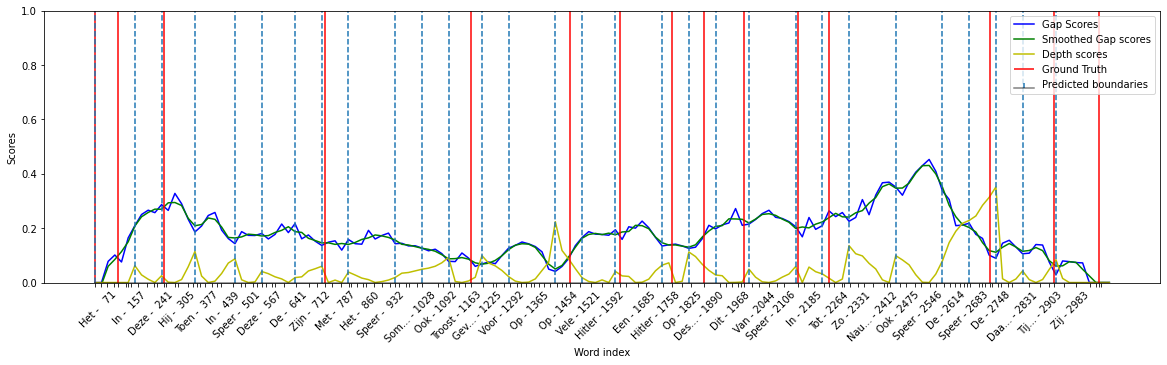

In [53]:
tt.plot(*res)